# Interpolate Sticky-Delta Volatility Smile with Python

In OTC FX option market, volatility smiles are quoted in a delta-volatilty instead of strike-volatility convention in equity option market. For pricing a given option, when one prepares volatility as a parameter in a Black-Scholes formula, they need to calculate the volatility for the given strike price from delta-volatility quotation.

## 1. Quoted in Delta (premium excluded)
Premium excluded delta is the case where the premium is paid in the quoted currency (ccy2) of a currency pair, for example EUR/USD. Here the deltas can be used for interpolation without any adjustment.

First, setup the market data.
You may notice that negative deltas are used, which means they are deltas of put. The reason will be explained in the section for premium included delta.

In [1]:
import QuantLib as ql
import math
import numpy as np
import matplotlib.pyplot as plt

as_of_date = ql.Date(1,2,2022)
# Market Data
tenors = [ql.Period('1M'), ql.Period('3M'), ql.Period('6M')]
maturities = [as_of_date + t for t in tenors]
voltilities = [[0.040, 0.030, 0.020, 0.025, 0.035], 
               [0.045, 0.040, 0.030, 0.035, 0.042],
               [0.060, 0.052, 0.035, 0.045, 0.048],
              ]
deltas = [[-0.90, -0.75, -0.5, -0.25, -0.10], 
          [-0.90, -0.75, -0.5, -0.25, -0.10], 
          [-0.90, -0.75, -0.5, -0.25, -0.10], 
         ]
delta_type = ql.DeltaVolQuote.Spot
rTS = ql.FlatForward(as_of_date, ql.QuoteHandle(ql.SimpleQuote(0.13)), ql.Actual365Fixed(), ql.Compounded, ql.Annual)
qTS = ql.FlatForward(as_of_date, ql.QuoteHandle(ql.SimpleQuote(0.01)), ql.Actual365Fixed(), ql.Compounded, ql.Annual)
spot = 1.1
strike = 1.2

Striky-delta is the quotation form that has delta for x-axis and volatility for y-axis. When we price a option with given strike, we firstly need to convert the strike to delta then map it to volatility. However, the delta formula needs both strike and volatility as inputs.
$${\Delta}_{put}(K,{\sigma}) = {e}^{-(r-q)t}N(-\frac{ln(\frac{S}{K})+(r-q+\frac{{\sigma}^2}{2})t}{{\sigma}\sqrt{t}})$$
Therefore, we need an initial guess of ${\sigma}_{1}$ as input together with ${K}$, and obtain ${\Delta}_{put}$ then interpolate ${\sigma}$ from the ${\Delta}$-${\sigma}$ quotation. Usually ${\sigma}_{ATM}$ is chosen to be the initial guess. The output ${\sigma}_{2}$ will be different from our input ${\sigma}_{1}$, so that we use ${\sigma}_{2}$ as input and repeat the step, until the input ${\sigma}_{n}$ and ouput ${\sigma}_{n+1}$ are close enough.

Let's setup a target function (as a class) for recurrsion. All the parameters are decided in `__init__` except ${\sigma}$ (argument `v0`). For the convertion from ${K}$ to ${\Delta}$, we leverage `BlackDeltaCalculator` class in QuantLib. This class has a method `deltaFromStrike` doing the convertion.

In this `TargetFun` class, $K$ (`strike`) is decided in the initialization stage. After that, in the call stage, we can plug the guess `v0` as ${\sigma}_{i}$ into `TargetFun(v0)` then obtain the difference of ${\sigma}_{i+1}$ and ${\sigma}_{i}$.

In [2]:
class TargetFun:
    def __init__(self, as_of_date, spot, rdf, qdf, strike, maturity, deltas, delta_type, smile, interp):
        self.ref_date = as_of_date
        self.strike = strike
        self.maturity = maturity
        self.spot = spot
        self.rDcf = rdf # discount factor
        self.qDcf = qdf # discount factor
        self.t = ql.Actual365Fixed().yearFraction(as_of_date, self.maturity)
        self.deltas = deltas
        self.interp = interp(self.deltas, smile)
        self.delta_type = delta_type
        
    def __call__(self, v0):
        optionType = ql.Option.Put
        stdDev = math.sqrt(self.t) * v0
        calc = ql.BlackDeltaCalculator(optionType, self.delta_type, self.spot, self.rDcf, self.qDcf, stdDev)
        d = calc.deltaFromStrike(self.strike)
        v = self.interp(d, allowExtrapolation=True)
        return (v - v0)

Choose a solver in QuantLib.

In [3]:
solver = ql.Brent()
accuracy = 1e-16
step = 1e-12

So far we have prepared the `TargetFun` and all the market data, now all we need to do is to give a $K$ and solve the `TargetFun` = 0. In order to plot a strike-volatility smile, we give a series of strikes then plot. In `strike2vol` function, for a given strike, we interpolate the volatility over the tenors, so that we can setup a term structure with `vts = ql.BlackVarianceCurve(...)`.

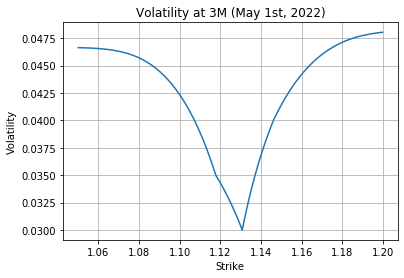

In [4]:
vol_vs_strike = []
strikes = np.linspace(1.05, 1.20, 500, endpoint=False)
display_maturity = as_of_date + ql.Period('3M')

def strike2vol(k):
    vol_by_tenor = []
    for i, smile in enumerate(voltilities):
        mat = maturities[i]
        target = TargetFun(as_of_date, 
                           spot,
                           rTS.discount(mat), 
                           qTS.discount(mat), 
                           k, 
                           maturities[i], 
                           deltas[i], 
                           delta_type, 
                           smile, 
                           ql.LinearInterpolation) # usually use cubic spline (ql.CubicNaturalSpline)
        guess = smile[2]
        vol_by_tenor.append(solver.solve(target, accuracy, guess, step))
    return vol_by_tenor

for k in strikes:
    vol_by_tenor = strike2vol(k)
    vts = ql.BlackVarianceCurve(as_of_date, 
                                maturities,
                                vol_by_tenor, 
                                ql.Actual365Fixed(), 
                                False)
    vts.enableExtrapolation()
    vts_handle = ql.BlackVolTermStructureHandle(vts)
    vol_vs_strike.append(vts_handle.blackVol(display_maturity, 1.0)) # the strike 1.0 has no effect

plt.plot(strikes, vol_vs_strike)
plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.title(f'Volatility at 3M ({display_maturity})')
plt.grid(True)
plt.show()

You may find that the smile is a little bit weird (the shape near ATM is very sharp, and the curvature is downward). It is because we choose linear interpolation instead of other smooth interpolation methods commonly used by traders. But one can easily replace `ql.LinearInterpolation` with `ql.CubicNaturalSpline` to align with market practice.

The ATM point is defined as the strike level where a option straddle has zero delta. This strike can be calculated by using put-call parity and this zero delta straddle. After some simple computation steps, the ATM strike will be
$${K}_{ATM} = {S}{e}^{r-q+\frac{{\sigma}^{2}}{2}{T}}$$
This ATM strike is slightly away from the forward price, here we will compute ${K}_{ATM}$ and its corresponding volatility to check this fact.

In [5]:
tt = ql.Actual365Fixed().yearFraction(as_of_date, display_maturity)
rdf = rTS.discount(display_maturity)
qdf = qTS.discount(display_maturity)
atm_strike = spot * math.exp(0.5 * tt * 0.030**2) / rdf * qdf
atm_vol_by_tenor = strike2vol(atm_strike)
vts = ql.BlackVarianceCurve(as_of_date, maturities, atm_vol_by_tenor, ql.Actual365Fixed(), False)
print(f'ATM strike = \t\t{atm_strike}')
print(f'ATM volatility = \t{vts.blackVol(display_maturity, 1.0)}')

ATM strike = 		1.1306522432146093
ATM volatility = 	0.03002432862311605


# 2. Quoted in Premium-included Delta
Deltas with premium are used in quotation where the premium is paid in base currency (ccy1) for a currency pair. For example, for pairs containing USD, USD is the premium currency except in the cases of EUR-, GBP, AUD- and NZD-.
In this type of quotation, premium is deducted from the Black-Scholes delta. The reason is, for dynamic hedging, option seller need to hold ${\Delta}$ unit of ccy1 (asset), he has already received the premium of $\frac{{V}_{ccy1}}{S}$ in ccy1, therefore he only needs to buy ${\Delta}-\frac{{V}_{ccy1}}{S}$ unit of ccy1.
In this case, before we do our interpolation on ${\Delta}$ dimension, we need to convert the permium-included delta into a pure delta. QuantLib's `BlackDeltaCalculator` class can help us. We initialize this class with `dt=ql.DeltaVolQuote.PaSpot` to tell it premium-included delta is in used.

Here we revise the `TargetFun` by adding a loop to convert premium-included delta to pure delta. We use `BlackDeltaCalculator(dt=ql.DeltaVolQuote.PaSpot, ...)` and `.strikeFormDelta` to obtain `k` then `BlackDeltaCalculator(dt=ql.DeltaVolQuote.Spot, ...)` and `.deltaFromStrike` to get pure `deltas`.

In [6]:
class TargetFun:
    def __init__(self, as_of_date, spot, rdf, qdf, strike, maturity, deltas, delta_type, smile, interp):
        self.ref_date = as_of_date
        self.strike = strike
        self.maturity = maturity
        self.spot = spot
        self.rDcf = rdf # discount factor
        self.qDcf = qdf # discount factor
        self.t = ql.Actual365Fixed().yearFraction(as_of_date, self.maturity)
        self.deltas = []
        
        for i, delta in enumerate(deltas):
            if not delta_type == ql.DeltaVolQuote.Spot:
                stdDev = math.sqrt(self.t) * smile[i]
                calc = ql.BlackDeltaCalculator(ql.Option.Put, delta_type, self.spot, self.rDcf, self.qDcf, stdDev)
                k = calc.strikeFromDelta(deltas[i])
                calc = ql.BlackDeltaCalculator(ql.Option.Put, ql.DeltaVolQuote.Spot, self.spot, self.rDcf, self.qDcf, stdDev)
                self.deltas.append(calc.deltaFromStrike(k))
        
        self.interp = interp(self.deltas, smile)
        self.delta_type = ql.DeltaVolQuote.Spot
        
    def __call__(self, v0):
        optionType = ql.Option.Put
        stdDev = math.sqrt(self.t) * v0
        calc = ql.BlackDeltaCalculator(optionType, self.delta_type, self.spot, self.rDcf, self.qDcf, stdDev)
        d = calc.deltaFromStrike(self.strike)
        v = self.interp(d, allowExtrapolation=True)
        return (v - v0)

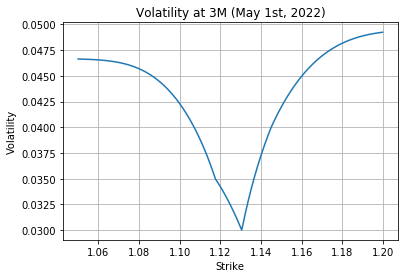

In [7]:
delta_type = ql.DeltaVolQuote.PaSpot
vol_vs_strike = []
strikes = np.linspace(1.05, 1.20, 500, endpoint=False)
display_maturity = as_of_date + ql.Period('3M')

def strike2vol(k):
    vol_by_tenor = []
    for i, smile in enumerate(voltilities):
        mat = maturities[i]
        target = TargetFun(as_of_date, 
                           spot,
                           rTS.discount(mat), 
                           qTS.discount(mat), 
                           k, 
                           maturities[i], 
                           deltas[i], 
                           delta_type, 
                           smile, 
                           ql.LinearInterpolation) # usually use cubic spline (ql.CubicNaturalSpline)
        guess = smile[2]
        vol_by_tenor.append(solver.solve(target, accuracy, guess, step))
    return vol_by_tenor

for k in strikes:
    vol_by_tenor = strike2vol(k)
    vts = ql.BlackVarianceCurve(as_of_date, maturities, vol_by_tenor, ql.Actual365Fixed(), False)
    vts.enableExtrapolation()
    vts_handle = ql.BlackVolTermStructureHandle(vts)
    vol_vs_strike.append(vts_handle.blackVol(display_maturity, 1.0)) # the strike 1.0 has no effect

plt.plot(strikes, vol_vs_strike)
plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.title(f'Volatility at 3M ({display_maturity})')
plt.grid(True)
plt.show()

## 3. Put Delta vs Call Delta
Here we want to explain the reason of choosing put deltas instead of call deltas for interpolation.
For a call option, premium-included delta is its B.S. delta less option premium or ${\Delta}_{Call}-\frac{{V}_{ccy1}}{S}$. For an in-of-money options, $\frac{{V}_{ccy1}}{S}$ can be relatively large compared to ${\Delta}_{Call}$, so the ${\Delta}_{Call}^{Pa}({K})$ is not a monotone function. In this case, the convertion from ${K}$ to ${\Delta}_{Call}^{Pa}$ is not unique, which may lead to undesired result.

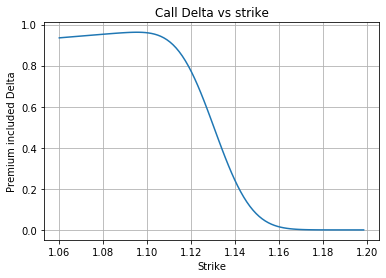

In [8]:
stdDev = 0.20 * tt**2
k_space = np.linspace(1.06, 1.20, 100, endpoint=False)
delta_space = []
for k in k_space:
    calc = ql.BlackDeltaCalculator(ql.Option.Call, ql.DeltaVolQuote.PaSpot, spot, rdf, qdf, stdDev)
    delta_space.append(calc.deltaFromStrike(k))
plt.plot(k_space, delta_space)
plt.xlabel('Strike')
plt.ylabel('Premium included Delta')
plt.title(f'Call Delta vs strike')
plt.grid(True)
plt.show()

In contrast, ${\Delta}_{Put}-\frac{{V}_{ccy1}}{S}$ is monotone to ${K}$, because ${\Delta}_{Put}$ is always negative.

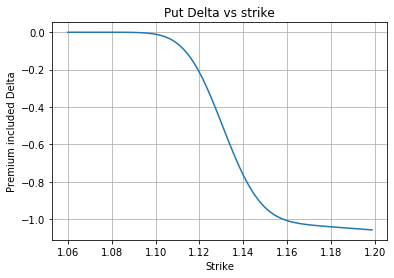

In [9]:
delta_space = []
for k in k_space:
    calc = ql.BlackDeltaCalculator(ql.Option.Put, ql.DeltaVolQuote.PaSpot, spot, rdf, qdf, stdDev)
    delta_space.append(calc.deltaFromStrike(k))
plt.plot(k_space, delta_space)
plt.xlabel('Strike')
plt.ylabel('Premium included Delta')
plt.title(f'Put Delta vs strike')
plt.grid(True)
plt.show()